In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7500)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

GPU ready


In [2]:
import pandas as pd

category_csv = pd.read_csv('./category/category.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'soju': 0, 'soda': 1, 'beer': 2, 'wine': 3, 'vita': 4, 'glass': 5, 'colorless_soju': 6, 'colorless_bottle': 7, 'color_bottle': 8}


In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = './image_data/통합본'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(64, 256),
        classes=label_dict,
        subset='training',
        batch_size = 64,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(64, 256),
        classes=label_dict,
        subset='validation',
        batch_size = 64,
        class_mode="sparse"
    )


Found 925 images belonging to 9 classes.
Found 227 images belonging to 9 classes.


In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.optimizers import Adam,SGD


with tf.device('/device:GPU:0'):

    densenet_model_base = DenseNet201(weights='imagenet',
                       include_top=False,
                       input_shape=(64,256,3))

    densenet_model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()

    model.add(densenet_model_base)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(9,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # adjust learning rate
    def get_lr_callback():
        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 12 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback
    
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_densenet_nozoom.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 200
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping, get_lr_callback()],
        steps_per_epoch=925//64+1, 
        validation_data=validationGen,
        validation_steps=227//64+1,
        verbose=1
    )



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 8, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 17289     
Total params: 18,339,273
Trainable params: 17,289
Non-trainable params: 18,321,984
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
15/15 [==============================] - ETA: 0s - loss: 2.5662 - sparse_categorical_accuracy: 0.1243
Epoch 00001: val_loss improved from inf to 2.69649, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 12s 793ms/step - loss: 2.5662 - s

15/15 [==============================] - 6s 392ms/step - loss: 2.0423 - sparse_categorical_accuracy: 0.2714 - val_loss: 2.1607 - val_sparse_categorical_accuracy: 0.2599
Epoch 20/200
15/15 [==============================] - ETA: 0s - loss: 1.9529 - sparse_categorical_accuracy: 0.2995
Epoch 00020: val_loss improved from 2.16067 to 2.15430, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 399ms/step - loss: 1.9529 - sparse_categorical_accuracy: 0.2995 - val_loss: 2.1543 - val_sparse_categorical_accuracy: 0.2599
Epoch 21/200
15/15 [==============================] - ETA: 0s - loss: 1.9544 - sparse_categorical_accuracy: 0.3222
Epoch 00021: val_loss improved from 2.15430 to 2.14757, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 417ms/step - loss: 1.9544 - sparse_categorical_accuracy: 0.3222 - val_loss: 2.1476 - val_sparse_categorical_accuracy: 0.2643
Epoch 22/200
15/15 [=============================

15/15 [==============================] - 5s 357ms/step - loss: 1.8388 - sparse_categorical_accuracy: 0.3514 - val_loss: 2.0453 - val_sparse_categorical_accuracy: 0.2907
Epoch 41/200
15/15 [==============================] - ETA: 0s - loss: 1.8529 - sparse_categorical_accuracy: 0.3546
Epoch 00041: val_loss improved from 2.04535 to 2.04047, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 351ms/step - loss: 1.8529 - sparse_categorical_accuracy: 0.3546 - val_loss: 2.0405 - val_sparse_categorical_accuracy: 0.2907
Epoch 42/200
15/15 [==============================] - ETA: 0s - loss: 1.8597 - sparse_categorical_accuracy: 0.3449
Epoch 00042: val_loss improved from 2.04047 to 2.03576, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 360ms/step - loss: 1.8597 - sparse_categorical_accuracy: 0.3449 - val_loss: 2.0358 - val_sparse_categorical_accuracy: 0.2952
Epoch 43/200
15/15 [=============================

15/15 [==============================] - 6s 372ms/step - loss: 1.7328 - sparse_categorical_accuracy: 0.3827 - val_loss: 1.9490 - val_sparse_categorical_accuracy: 0.3260
Epoch 62/200
15/15 [==============================] - ETA: 0s - loss: 1.7527 - sparse_categorical_accuracy: 0.3859
Epoch 00062: val_loss improved from 1.94895 to 1.94446, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 369ms/step - loss: 1.7527 - sparse_categorical_accuracy: 0.3859 - val_loss: 1.9445 - val_sparse_categorical_accuracy: 0.3260
Epoch 63/200
15/15 [==============================] - ETA: 0s - loss: 1.7494 - sparse_categorical_accuracy: 0.3978
Epoch 00063: val_loss improved from 1.94446 to 1.94023, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 359ms/step - loss: 1.7494 - sparse_categorical_accuracy: 0.3978 - val_loss: 1.9402 - val_sparse_categorical_accuracy: 0.3304
Epoch 64/200
15/15 [=============================

15/15 [==============================] - 5s 361ms/step - loss: 1.6382 - sparse_categorical_accuracy: 0.4335 - val_loss: 1.8631 - val_sparse_categorical_accuracy: 0.3524
Epoch 83/200
15/15 [==============================] - ETA: 0s - loss: 1.6633 - sparse_categorical_accuracy: 0.4411
Epoch 00083: val_loss improved from 1.86313 to 1.85914, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 383ms/step - loss: 1.6633 - sparse_categorical_accuracy: 0.4411 - val_loss: 1.8591 - val_sparse_categorical_accuracy: 0.3568
Epoch 84/200
15/15 [==============================] - ETA: 0s - loss: 1.6863 - sparse_categorical_accuracy: 0.4173
Epoch 00084: val_loss improved from 1.85914 to 1.85549, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 378ms/step - loss: 1.6863 - sparse_categorical_accuracy: 0.4173 - val_loss: 1.8555 - val_sparse_categorical_accuracy: 0.3568
Epoch 85/200
15/15 [=============================

15/15 [==============================] - 5s 357ms/step - loss: 1.5628 - sparse_categorical_accuracy: 0.4670 - val_loss: 1.7874 - val_sparse_categorical_accuracy: 0.3877
Epoch 104/200
15/15 [==============================] - ETA: 0s - loss: 1.5898 - sparse_categorical_accuracy: 0.4573
Epoch 00104: val_loss improved from 1.78737 to 1.78373, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 373ms/step - loss: 1.5898 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.7837 - val_sparse_categorical_accuracy: 0.3877
Epoch 105/200
15/15 [==============================] - ETA: 0s - loss: 1.5715 - sparse_categorical_accuracy: 0.4595
Epoch 00105: val_loss improved from 1.78373 to 1.78042, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 358ms/step - loss: 1.5715 - sparse_categorical_accuracy: 0.4595 - val_loss: 1.7804 - val_sparse_categorical_accuracy: 0.3877
Epoch 106/200
15/15 [==========================

15/15 [==============================] - 5s 358ms/step - loss: 1.5125 - sparse_categorical_accuracy: 0.4919 - val_loss: 1.7195 - val_sparse_categorical_accuracy: 0.4141
Epoch 125/200
15/15 [==============================] - ETA: 0s - loss: 1.5366 - sparse_categorical_accuracy: 0.4562
Epoch 00125: val_loss improved from 1.71952 to 1.71655, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 6s 367ms/step - loss: 1.5366 - sparse_categorical_accuracy: 0.4562 - val_loss: 1.7166 - val_sparse_categorical_accuracy: 0.4185
Epoch 126/200
15/15 [==============================] - ETA: 0s - loss: 1.5118 - sparse_categorical_accuracy: 0.4908
Epoch 00126: val_loss improved from 1.71655 to 1.71294, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 359ms/step - loss: 1.5118 - sparse_categorical_accuracy: 0.4908 - val_loss: 1.7129 - val_sparse_categorical_accuracy: 0.4185
Epoch 127/200
15/15 [==========================

15/15 [==============================] - 5s 317ms/step - loss: 1.4334 - sparse_categorical_accuracy: 0.5189 - val_loss: 1.6585 - val_sparse_categorical_accuracy: 0.4273
Epoch 146/200
15/15 [==============================] - ETA: 0s - loss: 1.4503 - sparse_categorical_accuracy: 0.5081
Epoch 00146: val_loss improved from 1.65846 to 1.65573, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 320ms/step - loss: 1.4503 - sparse_categorical_accuracy: 0.5081 - val_loss: 1.6557 - val_sparse_categorical_accuracy: 0.4273
Epoch 147/200
15/15 [==============================] - ETA: 0s - loss: 1.4169 - sparse_categorical_accuracy: 0.5157
Epoch 00147: val_loss improved from 1.65573 to 1.65305, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 318ms/step - loss: 1.4169 - sparse_categorical_accuracy: 0.5157 - val_loss: 1.6530 - val_sparse_categorical_accuracy: 0.4273
Epoch 148/200
15/15 [==========================

15/15 [==============================] - 5s 314ms/step - loss: 1.4056 - sparse_categorical_accuracy: 0.5297 - val_loss: 1.6027 - val_sparse_categorical_accuracy: 0.4361
Epoch 167/200
15/15 [==============================] - ETA: 0s - loss: 1.3889 - sparse_categorical_accuracy: 0.5168
Epoch 00167: val_loss improved from 1.60272 to 1.60117, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 318ms/step - loss: 1.3889 - sparse_categorical_accuracy: 0.5168 - val_loss: 1.6012 - val_sparse_categorical_accuracy: 0.4361
Epoch 168/200
15/15 [==============================] - ETA: 0s - loss: 1.3624 - sparse_categorical_accuracy: 0.5384
Epoch 00168: val_loss improved from 1.60117 to 1.59901, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 321ms/step - loss: 1.3624 - sparse_categorical_accuracy: 0.5384 - val_loss: 1.5990 - val_sparse_categorical_accuracy: 0.4361
Epoch 169/200
15/15 [==========================

15/15 [==============================] - 5s 319ms/step - loss: 1.3164 - sparse_categorical_accuracy: 0.5546 - val_loss: 1.5532 - val_sparse_categorical_accuracy: 0.4493
Epoch 188/200
15/15 [==============================] - ETA: 0s - loss: 1.3304 - sparse_categorical_accuracy: 0.5405
Epoch 00188: val_loss improved from 1.55319 to 1.55061, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 319ms/step - loss: 1.3304 - sparse_categorical_accuracy: 0.5405 - val_loss: 1.5506 - val_sparse_categorical_accuracy: 0.4493
Epoch 189/200
15/15 [==============================] - ETA: 0s - loss: 1.3216 - sparse_categorical_accuracy: 0.5319
Epoch 00189: val_loss improved from 1.55061 to 1.54901, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 5s 317ms/step - loss: 1.3216 - sparse_categorical_accuracy: 0.5319 - val_loss: 1.5490 - val_sparse_categorical_accuracy: 0.4493
Epoch 190/200
15/15 [==========================

In [7]:
model_path = './model/recycle_densenet.h5'
dense_model = tf.keras.models.load_model(model_path)



with tf.device('/device:GPU:0'):


    dense_model.compile(optimizer=RectifiedAdam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    # adjust learning rate
    def get_lr_callback():
        lr_start   = 0.000001*10*0.5
        lr_max     = 0.0000005 * 12 * 10*0.5
        lr_min     = 0.000001 * 10*0.5
        lr_ramp_ep = 5
        lr_sus_ep  = 0
        lr_decay   = 0.8


        def lrfn(epoch):
            if epoch < lr_ramp_ep:
                lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
            elif epoch < lr_ramp_ep + lr_sus_ep:
                lr = lr_max    
            else:
                lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
            return lr

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
        return lr_callback
    
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_densenet_nozoom.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 500
    history = dense_model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=925//64+1, 
        validation_data=validationGen,
        validation_steps=227//64+1,
        verbose=1
    )

Epoch 1/500
15/15 [==============================] - ETA: 0s - loss: 0.4294 - sparse_categorical_accuracy: 0.8670
Epoch 00001: val_loss improved from inf to 0.75857, saving model to ./model/recycle_densenet_nozoom.h5
15/15 [==============================] - 7s 495ms/step - loss: 0.4294 - sparse_categorical_accuracy: 0.8670 - val_loss: 0.7586 - val_sparse_categorical_accuracy: 0.7048
Epoch 2/500
15/15 [==============================] - ETA: 0s - loss: 0.4327 - sparse_categorical_accuracy: 0.8551
Epoch 00002: val_loss did not improve from 0.75857
15/15 [==============================] - 4s 298ms/step - loss: 0.4327 - sparse_categorical_accuracy: 0.8551 - val_loss: 0.7586 - val_sparse_categorical_accuracy: 0.7048
Epoch 3/500
15/15 [==============================] - ETA: 0s - loss: 0.4372 - sparse_categorical_accuracy: 0.8670
Epoch 00003: val_loss did not improve from 0.75857
15/15 [==============================] - 4s 291ms/step - loss: 0.4372 - sparse_categorical_accuracy: 0.8670 - val_l

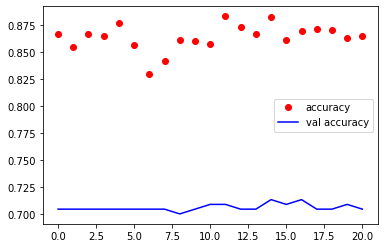

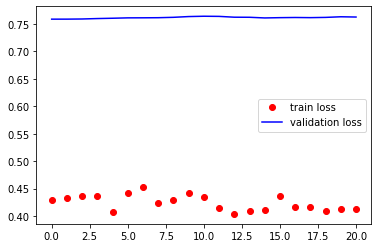

In [8]:

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

{0: 'soju', 1: 'soda', 2: 'beer', 3: 'wine', 4: 'vita', 5: 'glass', 6: 'colorless_soju', 7: 'colorless_bottle', 8: 'color_bottle'}
Instructions for updating:
Please use Model.predict, which supports generators.


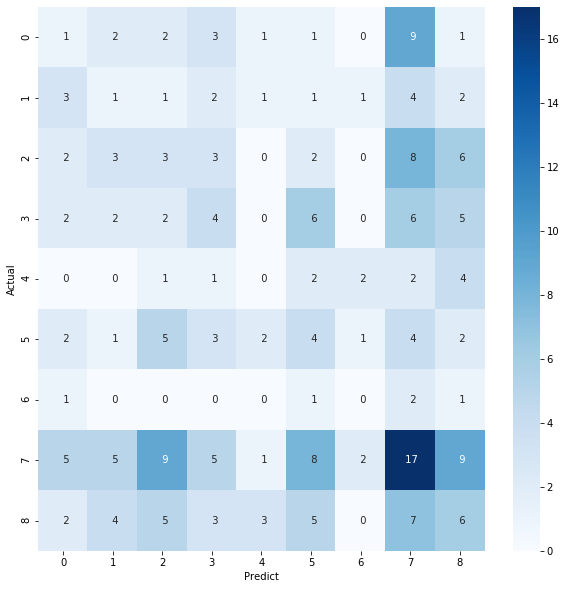

In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd



model_path = './model/recycle_densenet.h5' ## 경로 


dense_model = tf.keras.models.load_model(model_path)
category_list = list(category_csv['bottle_name'])


label_dict_reverse = dict(category_csv[['bottle_id','bottle_name']].values)
print(label_dict_reverse)
#Confution Matrix and Classification Report
Y_pred = dense_model.predict_generator(validationGen, 227//64+1)
y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# display(confusion_matrix(validationGen.classes, y_pred))



fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
sns.heatmap(
    confusion_matrix(validationGen.classes, y_pred),
    annot = True, # 숫자표현
    cbar = True,  # color bar 
    fmt = '3d',    # 정수표현     
    cmap = 'Blues', # color 색상
    ax = ax       # 그래프로 사용할 subplot
)
ax.set_xlabel('Predict')
ax.set_ylabel('Actual')
plt.show()